In [3]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import pandas
import os
from razdel import sentenize, tokenize
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import torch.nn.functional as F
import time
import torch
import torch.nn as nn
import numpy as np

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#and token not in russian_stopwords
#and token != " "]
#and token.strip() not in punctuation]
        
def ntlk_preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token.replace('\n', ' ').replace(' ', '') for token in tokens]
    tokens = [token for token in tokens if len(token) > 0 and token.strip() not in punctuation + '«' + '»' + '»,\xa0—' + ')']
    return tokens

def label_pipeline(label):
    possible = [0, -1, 1]
    return possible.index(label)

In [6]:
#NAVEC
from navec import Navec
from slovnet.model.emb import NavecEmbedding
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

def navec_text_pipeline(sentence):
    return list([navec[w] if w in navec else navec['<unk>'] for w in ntlk_preprocess_text(sentence)])

def navec_emb_text_pipeline(sentence, fixed_len=30):
    unk_index = navec.vocab.words.index('<unk>')
    index_list = list([navec.vocab.words.index(w) if w in navec else unk_index for w in ntlk_preprocess_text(sentence)])
    index_list = index_list + [unk_index for _ in range(fixed_len - len(index_list))]
    return index_list[:fixed_len]

In [7]:
from torch.utils.data import DataLoader

device = torch.device('cpu')

def collate_batch_to_sentence(batch):
    text_list = []
    for item in batch:
        distrbuted_repr = navec_text_pipeline(item[0]) #get list of embedded tokens
        distrbuted_repr = np.array(distrbuted_repr).mean(0) #aggregate into a single sentence vector
        text_list.append(distrbuted_repr)
    text_list = torch.tensor(text_list)
    label_list = torch.tensor([label_pipeline(item[5]) for item in batch])
    return text_list.to(device), label_list.to(device)

def collate_batch_to_navec_ids(batch):
    text_list = []
    for item in batch:
        navc_id_list = navec_emb_text_pipeline(item[0]) #get list of embedded tokens
        text_list.append(navc_id_list)
    text_list = torch.tensor(text_list)
    label_list = torch.tensor([label_pipeline(item[5]) for item in batch])
    return text_list.to(device), label_list.to(device)

In [4]:
class SingleLinearLayer(nn.Module):

    def __init__(self, embed_dim, num_class):
        super(SingleLinearLayer, self).__init__()
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        return self.fc(text)
    
class TextClassificationModel2Layer(nn.Module):

    def __init__(self, embed_dim, num_class):
        super(TextClassificationModel2Layer, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 10000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10000, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text_bow):
        fc1_out = self.fc1(text_bow)
        relu_out = self.relu(fc1_out)
        return self.fc2(relu_out)
    
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

t_vocab_size = len(navec.vocab.words)
t_embedding_dim = 300
t_n_filters = 3
t_filter_sizes = [3]
t_output_dim = 3
t_dropout = 0
t_pad_idx = None
model = CNN(t_vocab_size,
          t_embedding_dim,
          t_n_filters,
          t_filter_sizes,
          t_output_dim,
          t_dropout,
          t_pad_idx
         )

In [ ]:
nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim)) for fs in filter_sizes

In [48]:
#memory heavy!
from gensim.models import KeyedVectors
keyed_model = KeyedVectors(navec.pq.dim)
weights = navec.pq.unpack()  # warning! memory heavy
keyed_model.add_vectors(navec.vocab.words, weights)

In [49]:
embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights))
model.embedding = embedding
for param in model.embedding.parameters():
    param.requires_grad = False

In [5]:
from sklearn.metrics import f1_score

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 2
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5d}/{:5d} batches '
            #      '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
            #                                  total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            label = label
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [8]:
BATCH_SIZE = 4
train_part = 0.8

train_path = os.path.join(os.getcwd(), "train_data.csv")
train_df = pandas.read_csv(train_path, sep="\t")

train_len = int(len(train_df) * train_part)
train_data = train_df.values[:train_len]
test_data = train_df.values[train_len:]

#gradient accum

#kfold=KFold(n_splits=k_folds,shuffle=True)
#for fold,(train_idx, val_idx) in enumerate(kfold.split(train_df.values)):
#print(f"=====fold number {fold}=====")
train_data = train_data#train_df.values[:int(len)]
test_data = test_data#train_df.values[val_idx]
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch_to_navec_ids)
valid_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch_to_navec_ids)

In [ ]:
# Hyperparameters

EPOCHS = 3  # epoch
LR = 5  # learning rate
k_folds=5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

In [66]:
val_path = os.path.join(os.getcwd(), "validation_data.csv")
val_df = pandas.read_csv(val_path, sep="\t")

In [67]:
def collate_batch_valid(batch):
    text_list = []
    for item in batch:
        distrbuted_repr = navec_text_pipeline(item[0]) #get list of embedded tokens
        distrbuted_repr = np.array(distrbuted_repr).mean(0) #aggregate into a single sentence vector
        text_list.append(distrbuted_repr)
    text_list = torch.tensor(text_list)
    return text_list.to(device)

In [125]:
predicted_label = model(collate_batch_valid(test_data))
true_labels = [data[5] for data in test_data]
argmaxed_validation = predicted_label.argmax(1)
test_result = [[0, -1, 1][index] for index in argmaxed_validation]
print(f1_score(true_labels, test_result, average='macro'))

0.4272455158531108


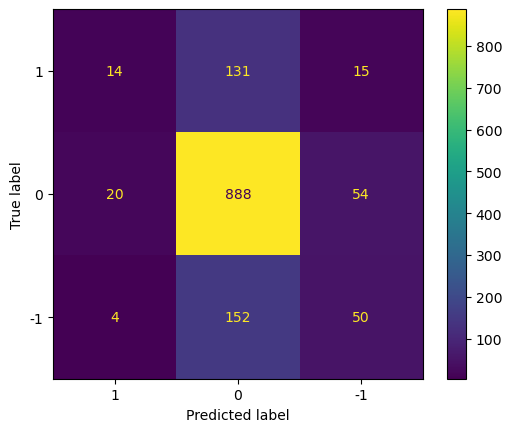

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, test_result, labels=[1, 0, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["1", "0", "-1"])
disp.plot()

In [150]:
f0_1_indeces = [index for (index, value) in enumerate(true_labels) if value == 1]
f0_1 = [fn_index for (value, fn_index) in zip(np.array(test_result)[f0_1_indeces], f0_1_indeces) if value == 0]
f0_1 = test_data[f0_1]

In [156]:
import eli5
eli5.show_weights(model, top=10)

In [97]:
predicted_label = model(collate_batch_valid(val_df.values))
argmaxed_validation = predicted_label.argmax(1)
valid_result = [[0, -1, 1][index] for index in argmaxed_validation]

In [71]:
d = {'col1': valid_result}
df = pandas.DataFrame(data=d)

In [ ]:
from collections import Counter
inp = inp
filtered = [c for c in inp if c not in [' ', '\n']]
counter = Counter(filtered)
max_val = max(counter.values())
c_list = list(counter.keys())
c_list.sort()
counter_len = len(counter)
strings = [['#' for _ in range(counter[char])] + [' ' for _ in range(max_val - counter[char])] for char in c_list]
strings_T = [['' for _ in range(len(counter))] for _ in range(max_val)]
for row_id in range(len(strings)):
    for col_id in range(len(strings[row_id])):
        strings_T[max_val - col_id - 1][row_id] = strings[row_id][col_id]
strings_T.append("".join(c_list))
custom = ["".join(t_row) for t_row in strings_T]
print('\n'.join(custom))